# Extract CMV
- use FRB method to extract CMV from pics in *example_pics* then save in .csv file

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv
import time
from datetime import timedelta


In [2]:
def bilinear_interp(pic_array, x_new, y_new):
    x0 = np.floor(x_new).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y_new).astype(int)
    y1 = y0 + 1
    x0 = np.clip(x0, 0, pic_array.shape[1]-1)
    x1 = np.clip(x1, 0, pic_array.shape[1]-1)
    y0 = np.clip(y0, 0, pic_array.shape[0]-1)
    y1 = np.clip(y1, 0, pic_array.shape[0]-1)
    
    Ia = pic_array[ y0, x0 ]
    Ib = pic_array[ y1, x0 ]
    Ic = pic_array[ y0, x1 ]
    Id = pic_array[ y1, x1 ]
    
    wa = (x1-x_new) * (y1-y_new)
    wb = (x1-x_new) * (y_new-y0)
    wc = (x_new-x0) * (y1-y_new)
    wd = (x_new-x0) * (y_new-y0)    
    new_pic_array = wa*Ia + wb*Ib + wc*Ic + wd*Id
    return new_pic_array

In [11]:
plant_df = pd.read_csv('plant.csv')
plant_df

site  CapacityDC_kW  CapacityAC_kW  row  col
0      1         996.48          875.0  832  863
1      2         199.88          175.0  849  850
2      3         992.25          875.0  852  864
3      4         425.25          375.0  853  870
4      5         992.25          875.0  849  884
..   ...            ...            ...  ...  ...
58    59            NaN       126126.0  754  852
59    60            NaN       133920.0  655  841
60    61            NaN        73000.0  772  884
61    62            NaN        52000.0  774  874
62    63            NaN        41000.0  773  877

[63 rows x 5 columns]

In [12]:
row_list = plant_df['row'].to_numpy()[:56] -1 
col_list = plant_df['col'].to_numpy()[:56] -1 

# Farneback

In [14]:
fb_params = dict(pyr_scale = 0.5, # recommend
    levels = 5 ,
    winsize = 20, 
    iterations = 3, 
    poly_n = 5,
    poly_sigma = 1.1,
    flags = 0)

In [23]:
datetime_list =pd.date_range('2022-03-23 10:50:00','2022-03-23 12:20:00 ',freq='10min')
datetime_list

DatetimeIndex(['2022-03-23 10:50:00', '2022-03-23 11:00:00',
               '2022-03-23 11:10:00', '2022-03-23 11:20:00',
               '2022-03-23 11:30:00', '2022-03-23 11:40:00',
               '2022-03-23 11:50:00', '2022-03-23 12:00:00',
               '2022-03-23 12:10:00', '2022-03-23 12:20:00'],
              dtype='datetime64[ns]', freq='10T')

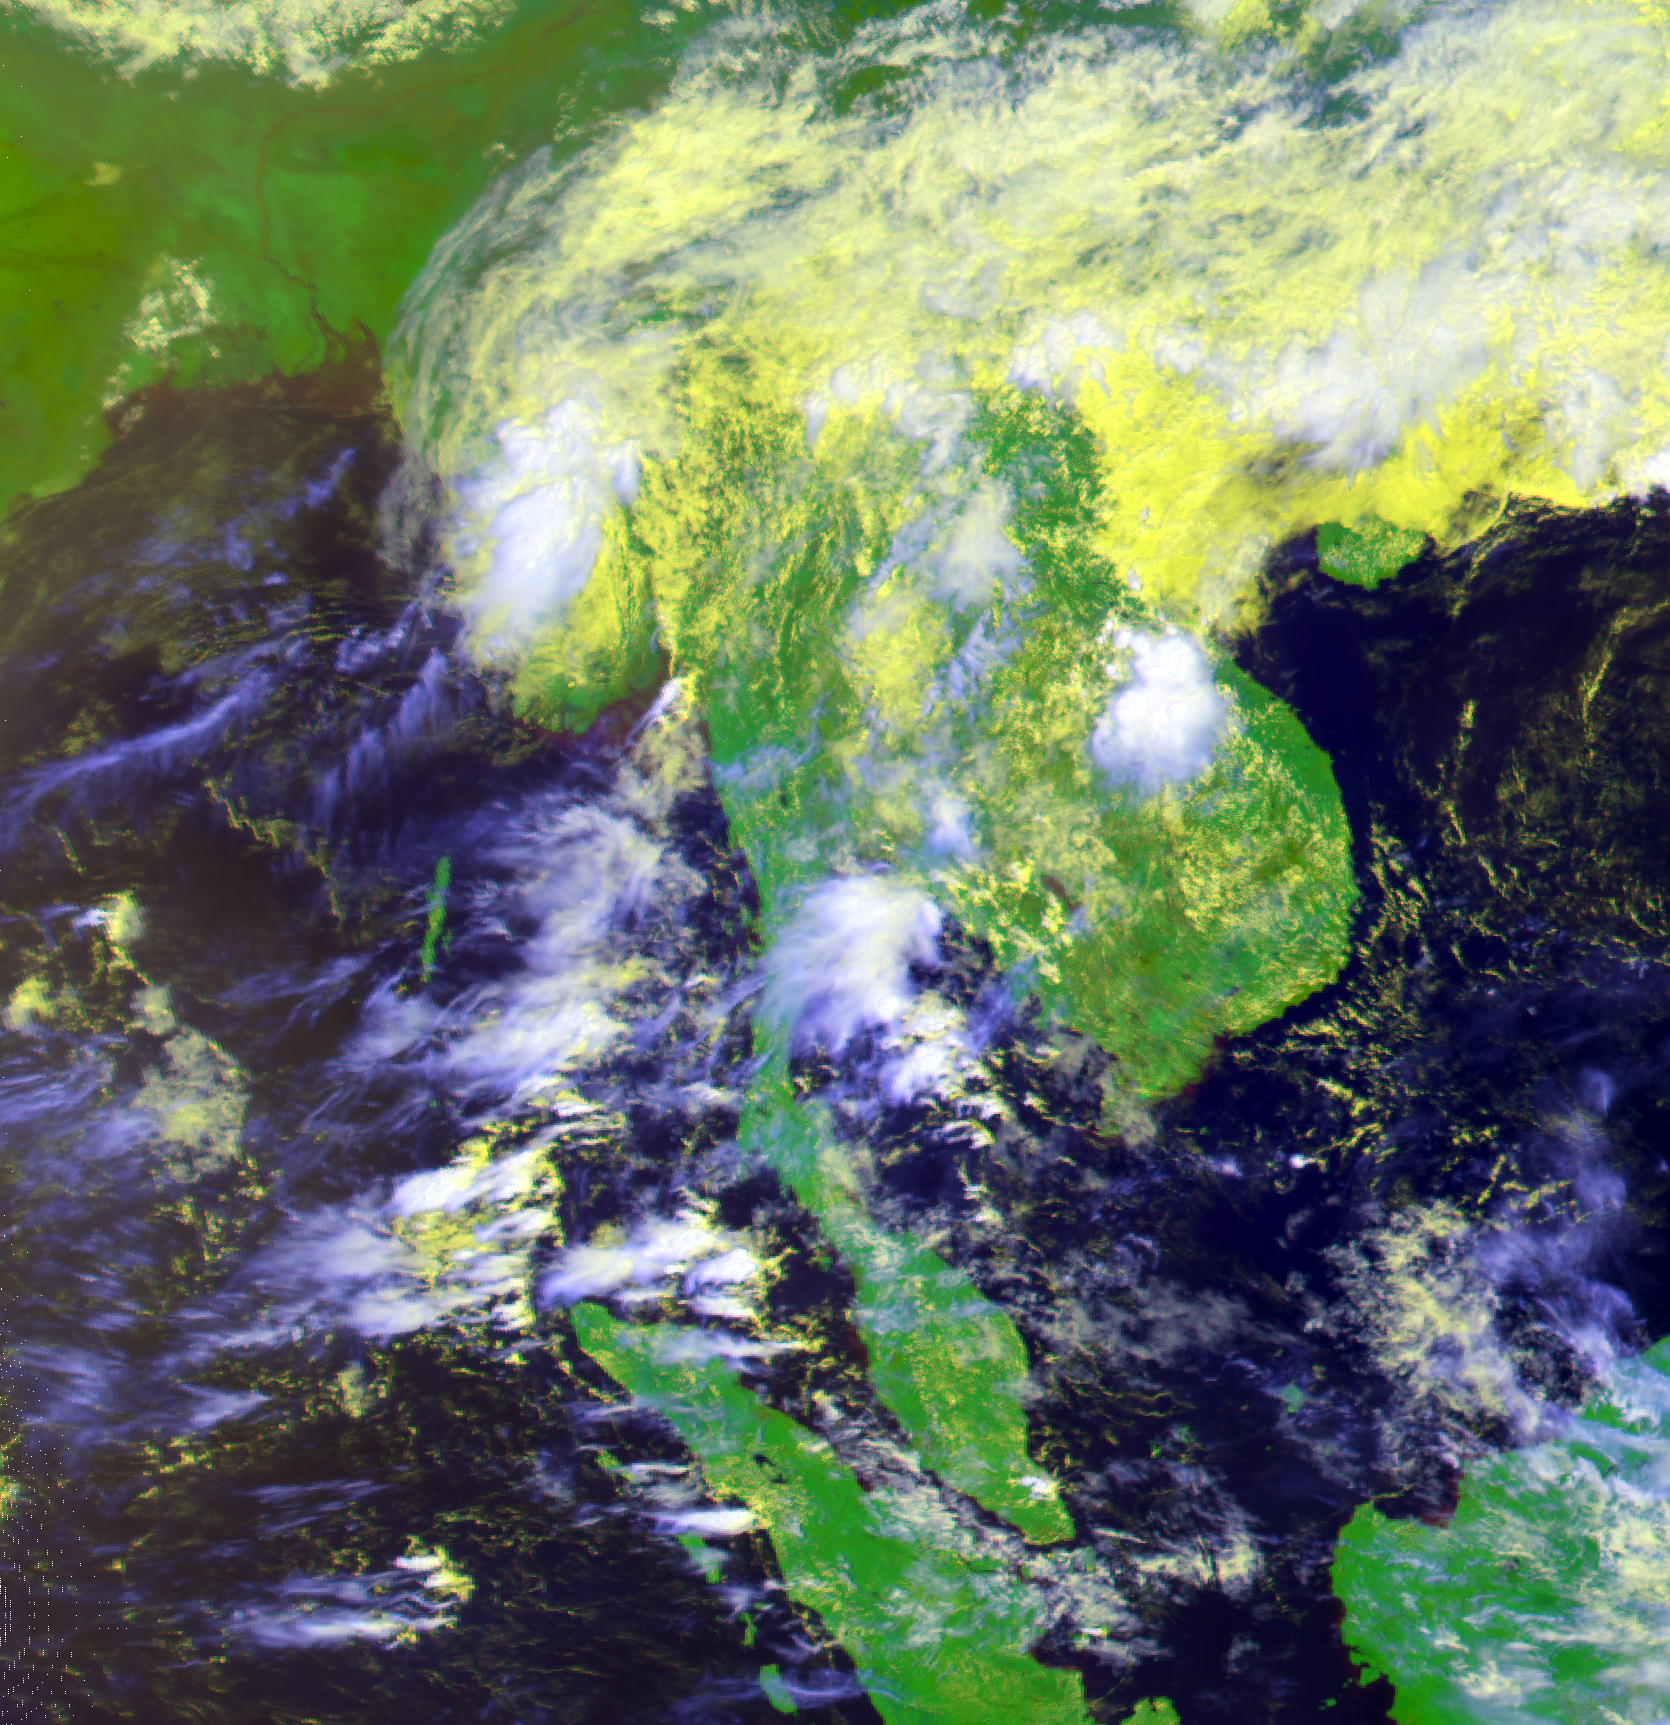

In [16]:
prev_im = Image.open('example_pics\himawari_ahi_overview_202203230350.tif')
prev_im

In [24]:
prev_im = Image.open('example_pics\himawari_ahi_overview_202203230350.tif')
prev_im_arr = np.array(prev_im)[:, :, 0] / 255
x = np.arange(prev_im_arr.shape[1])
y = np.arange(prev_im_arr.shape[0])
x_mesh, y_mesh = np.meshgrid(x, y)
ci_arr1step = np.zeros([len(datetime_list), 56])
ci_arr2step = np.zeros([len(datetime_list), 56])
ci_arr3step = np.zeros([len(datetime_list), 56])
ci_arr4step = np.zeros([len(datetime_list), 56])
ci_arr5step = np.zeros([len(datetime_list), 56])
ci_arr6step = np.zeros([len(datetime_list), 56])
ci_arr7step = np.zeros([len(datetime_list), 56])
ci_arr8step = np.zeros([len(datetime_list), 56])
k=0
notfound_status = False
for datetime in datetime_list :
    
    datetime_utc = datetime - timedelta(hours=7)
    curr_filename = f'example_pics\himawari_ahi_overview_{datetime_utc.strftime("%Y%m%d%H%M")}.tif'
    try :
        curr_im = Image.open(curr_filename)
        curr_im_arr = np.array(curr_im)[:, :, 0] / 255
        if notfound_status : 
            prev_im_arr = curr_im_arr
            notfound_status = False
            ci_arr1step[k, :] = np.nan
            ci_arr2step[k, :] = np.nan
            ci_arr3step[k, :] = np.nan
            ci_arr4step[k, :] = np.nan
            ci_arr5step[k, :] = np.nan
            ci_arr6step[k, :] = np.nan
            ci_arr7step[k, :] = np.nan
            ci_arr8step[k, :] = np.nan;k+=1
            print(k)
            # append with nan
            continue

        t0 = time.time()
        
        flow = cv.calcOpticalFlowFarneback(prev_im_arr , curr_im_arr,None,**fb_params)
        print(time.time()-t0)
        flow_x = flow[:, :, 0]
        flow_y = flow[:, :, 1]
        next_im_arr = curr_im_arr
        x_new = x_mesh - flow_x
        y_new = y_mesh - flow_y
        for i in range(1, 25):
            
            next_im_arr = bilinear_interp(next_im_arr, x_new, y_new)
            if i == 3:
                ci_arr1step[k,:] = next_im_arr[row_list, col_list]
            elif i == 6:
                ci_arr2step[k,:] = next_im_arr[row_list, col_list]
            elif i== 9:
                ci_arr3step[k,:] = next_im_arr[row_list, col_list]
            elif i == 12 :
                ci_arr4step[k,:] = next_im_arr[row_list, col_list]
            elif i == 15 :
                ci_arr5step[k,:] = next_im_arr[row_list, col_list]
            elif i == 18 :
                ci_arr6step[k,:] = next_im_arr[row_list, col_list]
            elif i == 21 :
                ci_arr7step[k,:] = next_im_arr[row_list, col_list]
            elif i == 24 :
                ci_arr8step[k,:] = next_im_arr[row_list, col_list]
        k+=1
        print(k)
        prev_im_arr = curr_im_arr
        
        
    except:
#       print(f'the picture of {datetime} not found')
        # append with nan 
        notfound_status = True
        ci_arr1step[k, :] = np.nan
        ci_arr2step[k, :] = np.nan
        ci_arr3step[k, :] = np.nan
        ci_arr4step[k, :] = np.nan
        ci_arr5step[k, :] = np.nan
        ci_arr6step[k, :] = np.nan
        ci_arr7step[k, :] = np.nan
        ci_arr8step[k, :] = np.nan;k+=1
        print(k, f'{curr_filename} Not Found')
        

example_pics\himawari_ahi_overview_202203230350.tif
1.7745347023010254
1
example_pics\himawari_ahi_overview_202203230400.tif
1.686629056930542
2
example_pics\himawari_ahi_overview_202203230410.tif
1.717991828918457
3
example_pics\himawari_ahi_overview_202203230420.tif
1.7009949684143066
4
example_pics\himawari_ahi_overview_202203230430.tif
1.7545192241668701
5
example_pics\himawari_ahi_overview_202203230440.tif
1.6069715023040771
6
example_pics\himawari_ahi_overview_202203230450.tif
1.6961357593536377
7
example_pics\himawari_ahi_overview_202203230500.tif
1.482100486755371
8
example_pics\himawari_ahi_overview_202203230510.tif
1.4899981021881104
9
example_pics\himawari_ahi_overview_202203230520.tif
1.5765187740325928
10


In [9]:
col_name = ['site'+ ('00' +str(no))[-3::] for no in range(1, 57)]
df1 = pd.DataFrame(ci_arr1step, columns=col_name)
df1['Datetime'] = datetime_list

df2 = pd.DataFrame(ci_arr2step, columns=col_name)
df2['Datetime'] = datetime_list

df3 = pd.DataFrame(ci_arr3step, columns=col_name)
df3['Datetime'] = datetime_list

df4 = pd.DataFrame(ci_arr4step, columns=col_name)
df4['Datetime'] = datetime_list

df5 = pd.DataFrame(ci_arr5step, columns=col_name)
df5['Datetime'] = datetime_list

df6 = pd.DataFrame(ci_arr6step, columns=col_name)
df6['Datetime'] = datetime_list

df7 = pd.DataFrame(ci_arr7step, columns=col_name)
df7['Datetime'] = datetime_list

df8 = pd.DataFrame(ci_arr8step, columns=col_name)
df8['Datetime'] = datetime_list

df1.to_csv('FRB_CI_1_step.csv', index=False)
df2.to_csv('FRB_CI_2_step.csv', index=False)
df3.to_csv('FRB_CI_3_step.csv', index=False)
df4.to_csv('FRB_CI_4_step.csv', index=False)
df5.to_csv('FRB_CI_5_step.csv', index=False)
df6.to_csv('FRB_CI_6_step.csv', index=False)
df7.to_csv('FRB_CI_7_step.csv', index=False)
df8.to_csv('FRB_CI_8_step.csv', index=False)